In [24]:
data <- read.csv('cleaneddata.csv')

'data.frame':	7032 obs. of  23 variables:
 $ customerID      : chr  "7590-VHVEG" "5575-GNVDE" "3668-QPYBK" "7795-CFOCW" ...
 $ gender          : int  1 2 2 2 1 1 2 1 1 2 ...
 $ SeniorCitizen   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Partner         : int  2 1 1 1 1 1 1 1 2 1 ...
 $ Dependents      : int  1 1 1 1 1 1 2 1 1 2 ...
 $ tenure          : int  1 34 2 45 2 8 22 10 28 62 ...
 $ PhoneService    : int  1 2 2 1 2 2 2 1 2 2 ...
 $ MultipleLines   : int  2 1 1 2 1 3 3 2 3 1 ...
 $ InternetService : int  1 1 1 1 2 2 2 1 2 1 ...
 $ OnlineSecurity  : int  1 3 3 3 1 1 1 3 1 3 ...
 $ OnlineBackup    : int  3 1 3 1 1 1 3 1 1 3 ...
 $ DeviceProtection: int  1 3 1 3 1 3 1 1 3 1 ...
 $ TechSupport     : int  1 1 1 3 1 1 1 1 3 1 ...
 $ StreamingTV     : int  1 1 1 1 1 3 3 1 3 1 ...
 $ StreamingMovies : int  1 1 1 1 1 3 1 1 3 1 ...
 $ Contract        : int  1 2 1 2 1 1 1 1 1 2 ...
 $ PaperlessBilling: int  2 1 2 1 2 2 2 1 2 1 ...
 $ PaymentMethod   : int  3 4 4 1 3 3 2 4 3 1 ...
 $ MonthlyCharges  :

In [2]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.1     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
#Convert PaperlessBilling into a factor
data <- data %>% 
    mutate(PaperlessBilling = as.factor(PaperlessBilling))

#Perform indepedendent samples t-test
t_test_result <- t.test(tenure ~ PaperlessBilling, data = data)
t_test_result



	Welch Two Sample t-test

data:  tenure by PaperlessBilling
t = -0.4041, df = 6136.8, p-value = 0.6862
alternative hypothesis: true difference in means between group 1 and group 2 is not equal to 0
95 percent confidence interval:
 -1.4097501  0.9278837
sample estimates:
mean in group 1 mean in group 2 
       32.27898        32.51991 


The p-value is 0.6862, which represents the probability of observing a t-value as extreme (or more) as -0.4041 under the null hypothesis (There is no difference in the average tenure between the two groups). 

Since the p-value is greater than the typical significance level of 0.05, we fail to reject the null hypothesis. This means that there is no statistically significant evidence to suggest that there is a difference in the average tenure between customers with and without paperless billing. 


To investigate if there is a significant difference in the average tenure between customers with different types of contracts, we first observe that this variable has more than 2 levels. Hence we cannot use the Welch t.test since it is desgined to compare the means of a continuous depenedent variable between two independent groups. 

In this case we can use one-way Analysis of Variance (ANOVA) to compare the means of a continuous dependent variable across multiple groups. 


In [4]:
data <- data %>% 
    mutate(Contract = as.factor(Contract))

#Perform indepedendent samples t-test
anova_result <- aov(tenure ~ Contract, data = data)
anova_result
anova_table <- summary(anova_result)
anova_table[[1]]

Call:
   aov(formula = tenure ~ Contract, data = data)

Terms:
                Contract Residuals
Sum of Squares   1962830   2273135
Deg. of Freedom        2      7029

Residual standard error: 17.98315
Estimated effects may be unbalanced

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Contract,2,1962830,981414.8995,3034.736,0
Residuals,7029,2273135,323.3938,NA,NA


The p-value is 0, which is less than the typical significance level of 0.05. This means that we can reject the null hypothesis, concluding that there **is a significant difference in the average tenure between at least one pair of contract types**. 

In [5]:
library(emmeans)
estimated_means <- emmeans(anova_result, ~ Contract)
post_hoc_result <- pairs(estimated_means, adjust = "tukey")
summary(post_hoc_result)

,contrast,estimate,SE,df,t.ratio,p.value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Contract1 - Contract2,-24.03672,0.5505936,7029,-43.65602,3.723799e-12
2,Contract1 - Contract3,-39.03516,0.5247681,7029,-74.38555,3.723799e-12
3,Contract2 - Contract3,-14.99844,0.6415777,7029,-23.37743,3.723799e-12


 The p-values have been adjusted for multiple comparisons using the Tukey method. For all three pairwise comparisons, the p-values are extremely small (3.723799e-12), which is much lower than the typical significance level of 0.05. This means that there is a statistically significant difference in the average tenure between each pair of contract types.

 In conclusion, the Tukey's HSD test results indicate that there are significant differences in the average tenure between all three contract types. Customers with a month-to-month contract have a significantly lower average tenure compared to those with one-year and two-year contracts. Similarly, customers with a one-year contract have a significantly lower average tenure compared to those with a two-year contract.





With this in mind, we will now attempt to identify high-risk customers with regards to churn. To do this, we will first be use the logistic regression model, which models the relationship between churn (as the dependent variable) and multiple independent variables, such as demographics, services, contract type, and billing information. Logistic regression can help us identify the most important factors that contribute to churn and estimate the likelihood of a customer churning based on these factors.

The summary of the process:

Feature Selection: Identify the most important features (independent variables) that have a significant impact on the target variable (churn). We will be using correlation analysis with a cutoff at 0.9 to ensure that only the most highly correlated variables are selected

Train the Model: We will split our dataset into a training and testing set (e.g., 70% training, 30% testing). We will then train a logistic regression model on the training set using the selected features as predictors and churn as the target variable.

Model Evaluation: We will then evaluate the performance of the logistic regression model on the testing set using metrics like accuracy, precision, recall, F1-score, and area under the ROC curve (AUC-ROC). 

Predict Churn Probability: Once the model is trained and validated, we will use it to predict the probability of churn for each customer in your dataset. This will give us a probability score between 0 and 1 for each customer.

Set a Threshold: We will then determine a threshold for the churn probability above which customers will be considered high-risk. In our case, we have arbitraily selected 0.7 as our threshold

Identify High-Risk Customers: Apply the threshold to the predicted churn probabilities to classify customers as high-risk or low-risk. Customers with churn probabilities above the threshold will be considered high-risk.



In [20]:
# Load necessary libraries
library(tidyverse)
library(caret)
library(glmnet)
library(pROC)
library(rpart)

# 2. Feature Selection: Correlation analysis 
numeric_columns <- data %>% select(-customerID, -Churn) %>% select_if(is.numeric)
correlations <- cor(numeric_columns)
high_correlations <- findCorrelation(correlations, cutoff = 0.9) # cutoff can be further tuned

# Get column names to be removed
remove_columns <- colnames(numeric_columns)[high_correlations]

# Filter out non-numeric columns
non_numeric_columns <- colnames(data) %>% setdiff(colnames(numeric_columns))
data_filtered <- data %>% select(-one_of(c(remove_columns, non_numeric_columns)))

# Add the Churn column back to the filtered dataset
data_filtered$Churn <- data$Churn
# Convert Churn column to binary numeric values
data_filtered$Churn <- ifelse(data_filtered$Churn == 1, 1, 0)


# 3. Train the Model: Split the data into training and testing sets
set.seed(123)
split <- createDataPartition(data_filtered$Churn, p = 0.7, list = FALSE)
train <- data_filtered[split,]
test <- data_filtered[-split,]



In [23]:
# Create logistic regression model
model <- glm(Churn ~ ., family = "binomial", data = train)

# 4. Model Evaluation: Evaluate model performance on the test set
predicted_probs <- predict(model, newdata = test, type = "response")
predicted_class <- ifelse(predicted_probs > 0.7, 1, 0) # Threshold set at 0.7, can be further tuned

conf_matrix <- confusionMatrix(factor(predicted_class), factor(test$Churn))
print(conf_matrix)

# 5. Predict Churn Probability: Use the model to predict churn probabilities for the entire dataset
churn_probs <- predict(model, newdata = data_filtered, type = "response")

# 6. Set a Threshold: Using ROC curve to find optimal threshold
roc_obj <- roc(data_filtered$Churn, churn_probs)
youdens_index <- roc_obj$sensitivities + roc_obj$specificities - 1
optimal_threshold <- roc_obj$thresholds[which.max(youdens_index)]

# 7. Identify High-Risk Customers: Classify customers based on the threshold
high_risk_customers <- data[ifelse(churn_probs > optimal_threshold, TRUE, FALSE),]

# Print high-risk customers
str(high_risk_customers)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0  476  254
         1   84 1295
                                          
               Accuracy : 0.8397          
                 95% CI : (0.8234, 0.8551)
    No Information Rate : 0.7345          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6254          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.8500          
            Specificity : 0.8360          
         Pos Pred Value : 0.6521          
         Neg Pred Value : 0.9391          
             Prevalence : 0.2655          
         Detection Rate : 0.2257          
   Detection Prevalence : 0.3461          
      Balanced Accuracy : 0.8430          
                                          
       'Positive' Class : 0               
                        

Setting levels: control = 0, case = 1

Setting direction: controls < cases



'data.frame':	4791 obs. of  23 variables:
 $ customerID      : chr  "5575-GNVDE" "3668-QPYBK" "1452-KIOVK" "6713-OKOMC" ...
 $ gender          : int  2 2 2 1 2 2 2 2 2 1 ...
 $ SeniorCitizen   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Partner         : int  1 1 1 1 1 2 1 2 1 2 ...
 $ Dependents      : int  1 1 2 1 2 2 1 1 1 2 ...
 $ tenure          : int  34 2 22 10 62 13 16 58 25 69 ...
 $ PhoneService    : int  2 2 2 1 2 2 2 2 2 2 ...
 $ MultipleLines   : int  1 1 3 2 1 1 1 3 1 3 ...
 $ InternetService : int  1 1 2 1 1 1 3 2 2 2 ...
 $ OnlineSecurity  : int  3 3 1 3 3 3 2 1 3 3 ...
 $ OnlineBackup    : int  1 3 3 1 3 1 2 1 1 3 ...
 $ DeviceProtection: int  3 1 1 1 1 1 2 3 3 3 ...
 $ TechSupport     : int  1 1 1 1 1 1 2 1 3 3 ...
 $ StreamingTV     : int  1 1 3 1 1 1 2 3 3 3 ...
 $ StreamingMovies : int  1 1 1 1 1 1 2 3 3 3 ...
 $ Contract        : Factor w/ 3 levels "1","2","3": 2 1 1 1 2 1 3 2 1 3 ...
 $ PaperlessBilling: Factor w/ 2 levels "1","2": 1 2 2 1 1 2 1 1 2 1 ...
 $ PaymentMethod 

TP (True Positives) = 1295: customers who were predicted to churn and actually churned.
TN (True Negatives) = 476: customers who were predicted not to churn and actually did not churn.
FP (False Positives) = 254: customers who were predicted to churn but did not churn.
FN (False Negatives) = 84: customers who were predicted not to churn but actually churned.
Accuracy: 0.8397 (95% CI: 0.8234, 0.8551)
The model's accuracy is 83.97%, meaning it correctly classified around 83.97% of the test dataset. The 95% confidence interval for the accuracy ranges from 82.34% to 85.51%.

No Information Rate (NIR): 0.7345
The NIR is the accuracy that could be achieved by always predicting the most frequent class. In this case, the most frequent class is '1' (not churn), with a proportion of 73.45%.

P-Value [Acc > NIR]: < 2.2e-16
The p-value tests whether the model's accuracy is significantly better than the NIR. A small p-value (e.g., < 0.05) indicates that the model's accuracy is significantly better than the NIR. In this case, the p-value is very small (< 2.2e-16), so the model is significantly better than always predicting the most frequent class.

Kappa: 0.6254
Cohen's Kappa measures the agreement between the model's predictions and the actual outcomes, accounting for the agreement that occurs by chance. A Kappa value of 1 indicates perfect agreement, while a value of 0 indicates agreement by chance. A Kappa of 0.6254 suggests a good level of agreement between the predictions and the actual outcomes.

Sensitivity (Recall): 0.8500
Sensitivity, also known as recall or true positive rate (TPR), measures the proportion of actual positives (churn) that were correctly identified by the model. In this case, the model correctly identified 85% of the customers who churned.

Specificity: 0.8360
Specificity, also known as the true negative rate (TNR), measures the proportion of actual negatives (non-churn) that were correctly identified by the model. In this case, the model correctly identified 83.6% of the customers who did not churn.

Positive Predictive Value (PPV, Precision): 0.6521
PPV, also known as precision, measures the proportion of true positives out of all the positive predictions made by the model. In this case, 65.21% of the customers predicted to churn actually churned.

Negative Predictive Value (NPV): 0.9391
NPV measures the proportion of true negatives out of all the negative predictions made by the model. In this case, 93.91% of the customers predicted not to churn actually did not churn.

Overall, the logistic regression model has good performance, with an accuracy of 83.97%, a Kappa of 0.625

We will now proceed to predict high-risk customers using another model - CART decision tree


In [13]:
# 5. Train the model: Decision Tree
model <- rpart(Churn ~ ., data = train, method = "class", control = rpart.control(minsplit = 20, cp = 0.001))

# 6. Make predictions
predictions <- predict(model, newdata = test, type = "class")

# 7. Evaluate the model
# Ensure that predictions and test_data$Churn have the same levels
predictions <- factor(predictions, levels = c(0, 1))
test$Churn <- factor(test$Churn, levels = c(0, 1))

# Calculate confusion matrix
confusionMatrix(predictions, test$Churn)




Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0  369  128
         1  191 1421
                                          
               Accuracy : 0.8487          
                 95% CI : (0.8327, 0.8638)
    No Information Rate : 0.7345          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5978          
                                          
 Mcnemar's Test P-Value : 0.0005179       
                                          
            Sensitivity : 0.6589          
            Specificity : 0.9174          
         Pos Pred Value : 0.7425          
         Neg Pred Value : 0.8815          
             Prevalence : 0.2655          
         Detection Rate : 0.1750          
   Detection Prevalence : 0.2357          
      Balanced Accuracy : 0.7881          
                                          
       'Positive' Class : 0               
                        

Comparing the evaluation metrics of CART decision tree vs the logistic regression:

CART Decision Tree:

Accuracy: 0.8487 

Kappa: 0.5978

Sensitivity (Recall): 0.6589

Specificity: 0.9174

Positive Predictive Value (Precision): 0.7425

Negative Predictive Value: 0.8815

Logistic Regression:


Accuracy: 0.8397

Kappa: 0.6254

Sensitivity (Recall): 0.8500

Specificity: 0.8360

Positive Predictive Value (Precision): 0.6521

Negative Predictive Value: 0.9391

Comparison:

The CART decision tree model has a slightly higher accuracy (84.87% vs. 83.97%).

The logistic regression model has a higher Kappa (0.6254 vs. 0.5978), indicating better agreement between predictions and actual outcomes after accounting for chance.

The logistic regression model has higher sensitivity (0.8500 vs. 0.6589), which means it's better at identifying customers who churn.

The CART decision tree model has higher specificity (0.9174 vs. 0.8360), which means it's better at identifying customers who do not churn.

The CART decision tree model has a higher PPV or precision (0.7425 vs. 0.6521), meaning a higher proportion of true positives among positive predictions.

The logistic regression model has a higher NPV (0.9391 vs. 0.8815), meaning a higher proportion of true negatives among negative predictions.

Overall, both models have their strengths and weaknesses, and the choice between them would depend on the specific business context and objectives. If correctly identifying customers who churn is more important, the logistic regression model may be more suitable. On the other hand, if correctly identifying customers who do not churn is more important, the CART decision tree model may be preferred.


 ダウンロードされたパッケージは、以下にあります 
 	/var/folders/p0/xr8c62gn79qghlvd5xp31xr40000gn/T//RtmpNPvUK9/downloaded_packages 


Warning message:
“labs do not fit even at cex 0.15, there may be some overplotting”


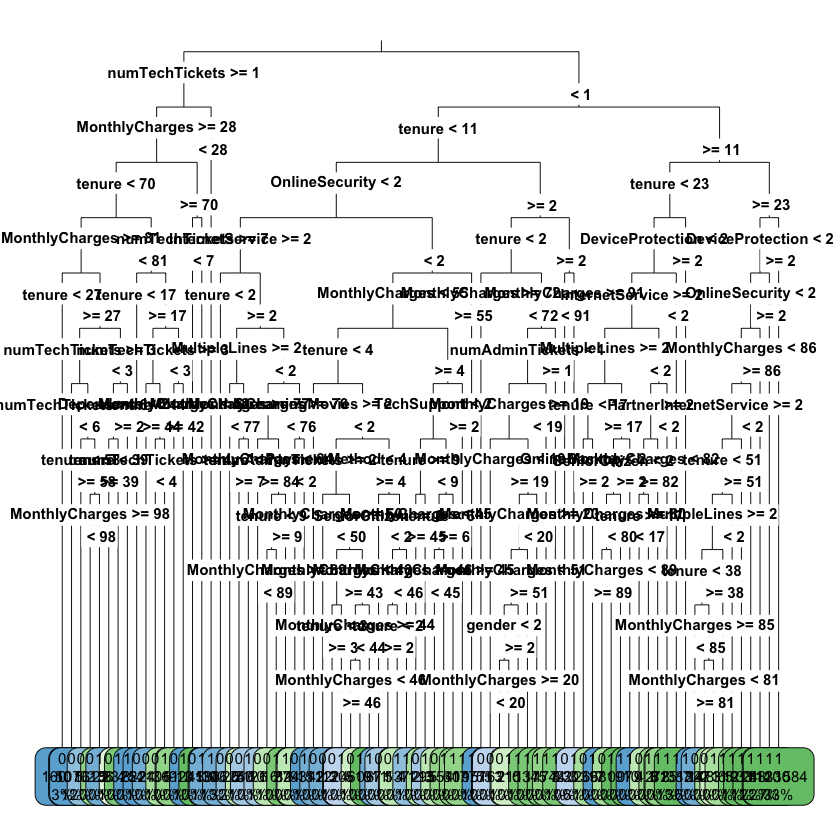

In [14]:
# Load the necessary libraries
library(rpart.plot)

# Plot the decision tree
rpart.plot(model, type = 3, extra = 101, cex = 0.75)


In [19]:
# Add the predictions to the test data
test$PredictedChurn <- predictions

# Filter high-risk customers
high_risk_customers <- test%>% filter(PredictedChurn == 1)

# Add customerID to the test data
test$customerID <- data$customerID[-split]

# Get customer information for high-risk customers
high_risk_customers_info <- data %>% filter(customerID %in% high_risk_customers$customerID)

str(high_risk_customers_info)


'data.frame':	1612 obs. of  23 variables:
 $ customerID      : chr  "3668-QPYBK" "7795-CFOCW" "1452-KIOVK" "6713-OKOMC" ...
 $ gender          : int  2 2 2 1 2 2 2 2 1 2 ...
 $ SeniorCitizen   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Partner         : int  1 1 1 1 1 2 1 1 2 2 ...
 $ Dependents      : int  1 1 2 1 2 2 1 1 2 1 ...
 $ tenure          : int  2 45 22 10 62 13 16 25 10 12 ...
 $ PhoneService    : int  2 1 2 1 2 2 2 2 2 2 ...
 $ MultipleLines   : int  1 2 3 2 1 1 1 1 1 1 ...
 $ InternetService : int  1 1 2 1 1 1 3 2 1 3 ...
 $ OnlineSecurity  : int  3 3 1 3 3 3 2 3 1 2 ...
 $ OnlineBackup    : int  3 1 3 1 3 1 2 1 1 2 ...
 $ DeviceProtection: int  1 3 1 1 1 1 2 3 3 2 ...
 $ TechSupport     : int  1 3 1 1 1 1 2 3 3 2 ...
 $ StreamingTV     : int  1 1 3 1 1 1 2 3 1 2 ...
 $ StreamingMovies : int  1 1 1 1 1 1 2 3 1 2 ...
 $ Contract        : Factor w/ 3 levels "1","2","3": 1 2 1 1 2 1 3 1 1 2 ...
 $ PaperlessBilling: Factor w/ 2 levels "1","2": 2 1 2 1 1 2 1 2 1 1 ...
 $ PaymentMethod 